# Project Motivation

## Related Works
- **Prompt-Tuning** methods such as [CoOp](https://arxiv.org/pdf/2109.01134) and [CoCoOp](https://arxiv.org/pdf/2203.05557) are prone to overfitting on the available few-shots per class. While they attack the problem from the prompt level i.e. language modality, they do not consider, hence leverage CLIP's shared embedding space between both vision and language modalities.

- On the other side, **Visual adapters** like [CLIP-Adapter](https://arxiv.org/pdf/2110.04544) try to attack the problem of few-shot-learning from the visual level by learning a residual on vision features (i.e. CLS token embedding from the ViT architecture) through a bottleneck layer. But, as per the prompt-tuning methods (CoOp and CoCoOp), they are also prone to overfitting on the available few-shots per class and alone, lack linguistics information.


## Analyses to motivate the workw
After implementing and reproducing both CLIP-Adapter and CoOp results, two analyses were performed to motivate the method developed in this project:
1. The first aimed to understand if performance degradation on unseen classes was tied to distance in embedding space between the embedded and unchanged textual prompt and the one resulting from concatenating CoOp's context tokens with tokens from the original prompt.

Formally, given the original text features 

<div style="text-align: center;">

<img src="https://i.postimg.cc/28r653Yw/clip-analysis.png" alt="image_caption" width="900">

**

</div>

2. In a similar fashion to analysis no. 1, the second was conducted such that to asses how visual features given by CLIP's frozen encoder diverged in embedding space from the learned representations by CLIP-Adapter i.e., the adapted features and if higher divergence would correspond in any way to a drop in performance for unseen classes. The results are shown in the figure below:
   
<div style="text-align: center;">

<img src="https://i.postimg.cc/L4z5RLcg/clip-adapter-analysis.png" alt="image_caption" width="900">

*As can be seen from this empirical analysis, it's clear how divergence in embedding space between adapted and non-adapted visual features is strongly correlated to degradation in novel class performance.*

</div>

## Problem
The problem with both approaches is that, in base-to-novel settings, they do not perform well as they:
1. Do not consider the shared embedding space between both vision and language modalities.
2. Do not actively implement any form of regularization to prevent overfitting on base classes and keep generalization performance on novel classes compared to CLIP zero-shot performance.

## Method
The idea of this project is to combine the two approaches mentioned above to leverage the shared embedding space between both vision and language modalities and to actively avoid learning both context tokens (for the language side) that yield text embeddings too far from frozen CLIP embeddings and adapted visual features that are prone to diverge from CLIP zero-shot embeddings, while still managing to learn task-specific features that helps discriminate better among (seen) base classes during training.

# Importing necessary libraries

In [1]:
%pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-5wcwd3sv
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-5wcwd3sv
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.9 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=5261c97f46ebd40bae1f6f770ef9e0ded54c8c50dec0a8df14fab1d784cecd32
  Stored in directory: /tmp/pip-ephem-wheel-cache-xfrfv1x4/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip


In [2]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
import torch
import torchvision
from torchvision.datasets.flowers102 import Flowers102
from torch.utils.data import Dataset
import torch.nn.functional as F
from tqdm import tqdm
from torch import nn, optim
import clip
import random
import numpy as np
from PIL import Image
import copy
from itertools import chain

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 43

## Utility Functions

In [ ]:
def base_novel_categories(dataset) -> tuple[list[int], list[int]]:
    # set returns the unique set of all dataset classes
    all_classes = set(dataset._labels)
    # and let's count them
    num_classes = len(all_classes)

    # here list(range(num_classes)) returns a list from 0 to num_classes - 1
    # then we slice the list in half and generate base and novel category lists
    base_classes = list(range(num_classes))[:num_classes // 2]
    novel_classes = list(range(num_classes))[num_classes // 2:]
    return base_classes, novel_classes


def harmonic_mean(base_accuracy, novel_accuracy):
    numerator = 2
    denominator = 1 / base_accuracy + 1 / novel_accuracy
    hm = numerator / denominator
    return hm


def get_data(data_dir='./data', transform=None) -> tuple[Flowers102,
                                                         Flowers102,
                                                         Flowers102]:
    """Load Flowers102 train, validation and test sets.
    Args:
        data_dir (str): Directory where the dataset will be stored.
        transform (torch.Compose)
    Returns:
        tuple: A tuple containing the train, validation, and test sets.
    """
    train = Flowers102(
        root=data_dir, split="train", download=True, transform=transform)
    val = Flowers102(
        root=data_dir, split="val", download=True, transform=transform)
    test = Flowers102(
        root=data_dir, split="test", download=True, transform=transform)
    return train, val, test


def split_data(dataset, base_classes):
    # these two lists will store the sample indexes
    base_categories_samples = []
    novel_categories_samples = []

    # we create a set of base classes to compute the test below in O(1)
    # this is optional and can be removed
    base_set = set(base_classes)

    # here we iterate over sample labels and also get the correspondent sample index
    for sample_id, label in enumerate(dataset._labels):
        if label in base_set:
            base_categories_samples.append(sample_id)
        else:
            novel_categories_samples.append(sample_id)

    # here we create the dataset subsets
    # the torch Subset is just a wrapper around the dataset
    # it simply stores the subset indexes and the original dataset (your_subset.dataset)
    # when asking for sample i in the subset, torch will look for its original position in the dataset and retrieve it
    # https://pytorch.org/docs/stable/data.html#torch.utils.data.Subset
    base_dataset = torch.utils.data.Subset(dataset, base_categories_samples)
    novel_dataset = torch.utils.data.Subset(dataset, novel_categories_samples)
    return base_dataset, novel_dataset


def accuracy(logits: torch.Tensor, labels: torch.Tensor) -> float:
    preds = torch.argmax(logits, dim=1)
    return (preds == labels).float().mean().item()


def train_one_epoch(
    teacher_model,
    student_model,
    dataloader,
    optimizer,
    base_indices,
    alpha=0.5,
    gamma=0.2,
    temperature=2.0
):
    teacher_model.train()
    total_loss, total_acc = 0.0, 0.0

    for imgs, labels in tqdm(dataloader, desc="Training", leave=False):
        orig_imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)

        # student forward pass
        student_img_feats, student_text_feats = student_model(orig_imgs)  # both with shape: [B, 102]
        # print("student text_features shape: ", student_text_feats.shape)

        # teacher forward pass
        with torch.no_grad():
            dtype = teacher_model.dtype
            teacher_img_feats = teacher_model.visual(orig_imgs.type(dtype))
            teacher_img_feats /= teacher_img_feats.norm(dim=-1, keepdim=True).clamp(min=1e-12)

            classnames = student_model.classnames
            template = "a photo of a {}, a type of flower."
            prompts = [template.format(c) for c in classnames]
            tokenized_prompts = torch.cat([clip.tokenize(p) for p in prompts]).to(DEVICE)
            teacher_text_feats = teacher_model.encode_text(tokenized_prompts)
            teacher_text_feats /= teacher_text_feats.norm(dim=-1, keepdim=True).clamp(min=1e-12)
            # print("teacher text_features shape: ", teacher_text_feats.shape)

        # calculate student and teacher logits
        logit_scale = student_model.logit_scale.exp()
        student_logits = logit_scale * student_img_feats @ student_text_feats.t()
        # note: vision logits are the cos. sim between teacher img feats (non adapted) and student text feats (adapted with CoOp).
        teacher_vision_logits = logit_scale * teacher_img_feats @ student_text_feats.t()

        student_logits_base = student_logits[:, base_indices]  # logtis for base classes only

        # CE loss on base classes only
        ce_loss = F.cross_entropy(student_logits_base, labels)

        # visual distillation loss (KL div.) with temperature
        vision_kd_loss = F.kl_div(
            F.log_softmax(student_logits / temperature, dim=-1),
            F.softmax(teacher_vision_logits / temperature, dim=-1),
            reduction='batchmean'
        ) * (temperature ** 2)

        # text feature-based KD loss
        text_kd_loss = 1 - F.cosine_similarity(
            student_text_feats, teacher_text_feats, dim=-1
        ).mean()

        # combined loss (vision_KD + text_KD + CE)
        loss = (alpha * ce_loss + (1 - alpha) * vision_kd_loss) + gamma * text_kd_loss # (visual KL + CE + text KD)
        #loss = (alpha * ce_loss + (1 - alpha) * vision_kd_loss) # (visual KL + CE)
        #loss = ce_loss + gamma * text_kd_loss # (CE + text KD)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc += accuracy(student_logits_base, labels)

    return total_loss / len(dataloader), total_acc / len(dataloader)


@torch.no_grad()
def eval(model, dataloader):
    model.eval()
    total_loss, total_acc = 0.0, 0.0

    for images, labels in tqdm(dataloader, desc="Evaluating", leave=False):
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        logit_scale = student_model.logit_scale.exp()
        img_feats, text_feats = model(images)
        logits = 100.0 * img_feats @ text_feats.t()
        loss = F.cross_entropy(logits, labels)

        total_loss += loss.item()
        total_acc += accuracy(logits, labels)

    return total_loss / len(dataloader), total_acc / len(dataloader)


def train_loop(
    teacher_model,
    student_model,
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    base_indices,
    epochs=10,
    patience=3,
    alpha=0.5,
    gamma=0.2,
    temperature=2,
    model_state_path='adapter_weights.pt'
):
    best_val_acc = 0.0
    best_model_state = None
    epochs_no_improve = 0
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(1, epochs + 1):
        print(f"\nEpoch: {epoch}/{epochs}")

        train_loss, train_acc = train_one_epoch(
            teacher_model, student_model, train_loader, optimizer,
            base_indices, alpha, gamma, temperature
        )
        val_loss, val_acc = eval(student_model, val_loader)

        scheduler.step()
        current_lr = scheduler.get_last_lr()[0]
        print(f"[LR] Current learning rate: {current_lr:.6f}")

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Train Loss: {train_loss:.4f} | Train Acc.: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Val Acc.: {val_acc:.4f}")

        # early stopping
        if patience < epochs:
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_vision_adapter_state = copy.deepcopy(student_model.vision_adapter.state_dict())
                best_ctx_state = copy.deepcopy(student_model.text_adapter.state_dict())
                torch.save(best_ctx_state, "ctx_state.pt")
                torch.save(best_vision_adapter_state, "vision_adapter_state.pt")
                print(f"✅ New best model saved (val_acc = {best_val_acc:.4f})")
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                print(f"No improvement for {epochs_no_improve} epoch(s)")
            if epochs_no_improve >= patience:
                print(f"⏹️ Early stopping at epoch {epoch} (best val_acc = {best_val_acc:.4f})")
                break

    return history


# -- Reproducibility utils --

def set_seed(seed: int = 42):
    """
    Settings used for reproducibility purposes.
    https://pytorch.org/docs/stable/notes/randomness.html
    """
    # Python & NumPy
    random.seed(seed)
    np.random.seed(seed)

    # Torch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Torch determinism
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f"[INFO] Seed set to {seed}")


def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


# Model Definition

### CLIP-Adapter

In [4]:
class VisionAdapter(nn.Module):
    def __init__(self, c_in, reduction=4, dropout=0.5):
        super(VisionAdapter, self).__init__()

        hidden_dim = c_in // reduction
        self.net = nn.Sequential(
            nn.Linear(in_features=c_in, out_features=hidden_dim, bias=False),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=hidden_dim, out_features=c_in, bias=False),
        )

    def forward(self, x):
        x = self.net(x)  # residual
        return x


class TextAdapter(nn.Module):
    def __init__(self, classnames, clip_model, n_ctx=16):
        super(TextAdapter, self).__init__()
        self.classnames = classnames
        self.dtype = clip_model.dtype

        ctx_dim = clip_model.ln_final.weight.shape[0]  # context dimension
        self.ctx = nn.Parameter(torch.empty(n_ctx, ctx_dim))  # tokens to be learned
        nn.init.normal_(self.ctx, std=0.02)

        prompt_prefix = " ".join(['X'] * n_ctx)
        print(f'Initial context: "{prompt_prefix}"')
        print(f"Number of context words (tokens): {n_ctx}")

        temp = 'a photo of a {}, a type of flower.'
        prompts = [temp.format(c) for c in classnames]
        prompts = [prompt_prefix + " " + p for p in prompts]
        tokenized_prompts = torch.cat([clip.tokenize(p) for p in prompts]).to(DEVICE)

        with torch.no_grad():
            embeddings = clip_model.token_embedding(tokenized_prompts).type(self.dtype)

        # structure is: [BOS] [class tokens ... ] [EOS]
        self.register_buffer("token_prefix", embeddings[:, :1, :])  # SOS
        self.register_buffer("token_suffix", embeddings[:, 1 + n_ctx :, :])  # class tokens + EOS
        self.tokenized_prompts = tokenized_prompts

    def forward(self, token_embeddings):
        # append the learnable context to the end of the token embeddings
        ctx = self.ctx.unsqueeze(0).expand(token_embeddings.shape[0], -1, -1)
        return torch.cat([
            self.token_prefix,  # BOS
            ctx,  # learned context
            self.token_suffix,  # class tokens + EOS
        ], dim=1).type(self.dtype)


### Custom CLIP

In [5]:
class CustomCLIP(nn.Module):
    def __init__(
        self,
        classnames: list[str],
        clip_model: nn.Module,
        vision_adapter_args,
        text_adapter_args,
        vision_ratio: float = 0.2,
        vision_adapter_state=None,
        text_adapter_state=None 
    ):
        super().__init__()
        self.classnames = classnames
        self.dtype = clip_model.dtype
        self.clip_model = clip_model
        self.vision_ratio = vision_ratio
        self.logit_scale = clip_model.logit_scale
        self.image_encoder = clip_model.visual

        # create and attach adapters
        vision_feature_dim = self.image_encoder.output_dim
        self.vision_adapter = VisionAdapter(vision_feature_dim, **vision_adapter_args)
        self.text_adapter = TextAdapter(classnames, clip_model, **text_adapter_args)

        if vision_adapter_state:
            self.vision_adapter.load_state_dict(vision_adapter_state)

        if text_adapter_state:
            self.text_adapter.load_state_dict(text_adapter_state)

    def encode_image_with_adapter(self, image):
        image_features = self.image_encoder(image.type(self.dtype))
        adapted_features = self.vision_adapter(image_features.float()).type(self.dtype)
        combined_features = self.vision_ratio * adapted_features + (1 - self.vision_ratio) * image_features
        # norm & return
        return combined_features / combined_features.norm(dim=-1, keepdim=True)

    def encode_text_with_adapter(self):
        text_embeddings = self.clip_model.token_embedding(
            self.text_adapter.tokenized_prompts).type(self.dtype)
        adapted_embeddings = self.text_adapter(text_embeddings)

        # pass through CLIP text transformer
        x = adapted_embeddings + self.clip_model.positional_embedding.type(self.dtype)
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.clip_model.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.clip_model.ln_final(x).type(self.dtype)

        text_features = x[torch.arange(x.shape[0]), self.text_adapter.tokenized_prompts.argmax(dim=-1)] @ self.clip_model.text_projection
        return text_features / text_features.norm(dim=-1, keepdim=True)

    def forward(self, images: torch.Tensor):
        # compute (normalized) text & image feats.
        image_features = self.encode_image_with_adapter(images.type(self.dtype))
        text_features = self.encode_text_with_adapter()
        return image_features, text_features

# Preparing the Dataset and CLIP

In [6]:
set_seed(SEED)

# Inspect classes
_, _, tmp_test = get_data()
base_classes, novel_classes = base_novel_categories(tmp_test)

CLASS_NAMES = [
    'pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold',
    'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle',
    'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris',
    'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily',
    'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth',
    'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william',
    'carnation', 'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly',
    'ruby-lipped cattleya', 'cape flower', 'great masterwort', 'siam tulip', 'lenten rose',
    'barbeton daisy', 'daffodil', 'sword lily', 'poinsettia', 'bolero deep blue',
    'wallflower', 'marigold', 'buttercup', 'oxeye daisy', 'common dandelion',
    'petunia', 'wild pansy', 'primula', 'sunflower', 'pelargonium',
    'bishop of llandaff', 'gaura', 'geranium', 'orange dahlia', 'pink-yellow dahlia',
    'cautleya spicata', 'japanese anemone', 'black-eyed susan', 'silverbush', 'californian poppy',
    'osteospermum', 'spring crocus', 'bearded iris', 'windflower', 'tree poppy',
    'gazania', 'azalea', 'water lily', 'rose', 'thorn apple',
    'morning glory', 'passion flower', 'lotus lotus', 'toad lily', 'anthurium',
    'frangipani', 'clematis', 'hibiscus', 'columbine', 'desert-rose',
    'tree mallow', 'magnolia', 'cyclamen', 'watercress', 'canna lily',
    'hippeastrum', 'bee balm', 'ball moss', 'foxglove', 'bougainvillea',
    'camellia', 'mallow', 'mexican petunia', 'bromelia', 'blanket flower',
    'trumpet creeper', 'blackberry lily'
]

# available models = ['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']
clip_model, preprocess = clip.load("ViT-B/16", device=DEVICE)

# get the three datasets
train_set, val_set, test_set = get_data(transform=preprocess)

# split classes into base and novel
base_classes, novel_classes = base_novel_categories(train_set)

# split the three datasets
train_base, _ = split_data(train_set, base_classes)
val_base, _ = split_data(val_set, base_classes)
test_base, test_novel = split_data(test_set, base_classes)

# Create data loaders
g = torch.Generator()
g.manual_seed(SEED)

BATCH_SIZE = 32

train_loader = torch.utils.data.DataLoader(
    train_base,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    generator=g,
    worker_init_fn=seed_worker
)

val_loader = torch.utils.data.DataLoader(
    val_base,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    generator=g,
    worker_init_fn=seed_worker
)

[INFO] Seed set to 43


100%|██████████| 345M/345M [00:18<00:00, 18.2MB/s] 
100%|██████████| 502/502 [00:00<00:00, 895kB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 37.0MB/s]
100%|███████████████████████████████████████| 335M/335M [00:04<00:00, 80.8MiB/s]


# Preparing the custom Model + Training

In [ ]:
epochs = 10
patience = 5
lr = 2e-3
wd = 1e-2
# vision adapter hyperparams.
vision_ratio = 0.2  # original paper is 0.2
vision_reduction = 16
vision_dropout = 0.4
vision_adapter_args = {"reduction": vision_reduction, "dropout": vision_dropout}
# CoOp hyperparam
n_ctx = 16
text_adapter_args = {"n_ctx": n_ctx}

# loss weights hyperparams.
# alpha * CE + (1-alpha) * visual_KD + gamma * text_KD
alpha = 0.6
# gamma = 0.5
gamma = 4
temperature = 3

# defining teacher / student models
teacher_model = clip_model
teacher_model.eval()

# freezing teacher (CLIP base)
for param in teacher_model.parameters():
    param.requires_grad = False

student_model = CustomCLIP(
    CLASS_NAMES,
    clip_model,
    vision_adapter_args=vision_adapter_args,
    text_adapter_args=text_adapter_args,
    vision_ratio=vision_ratio
).to(DEVICE)

trainable_params = chain(
    student_model.vision_adapter.parameters(),
    student_model.text_adapter.parameters(),
)

optimizer = optim.AdamW(trainable_params, lr=lr, weight_decay=wd)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

history = train_loop(
    teacher_model, student_model, train_loader, val_loader,
    optimizer, scheduler, epochs=epochs, patience=patience,
    base_indices=base_classes, alpha=alpha, gamma=gamma,
    temperature=temperature
)

Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/10


Training:  44%|████▍     | 7/16 [11:13<14:20, 95.57s/it] 

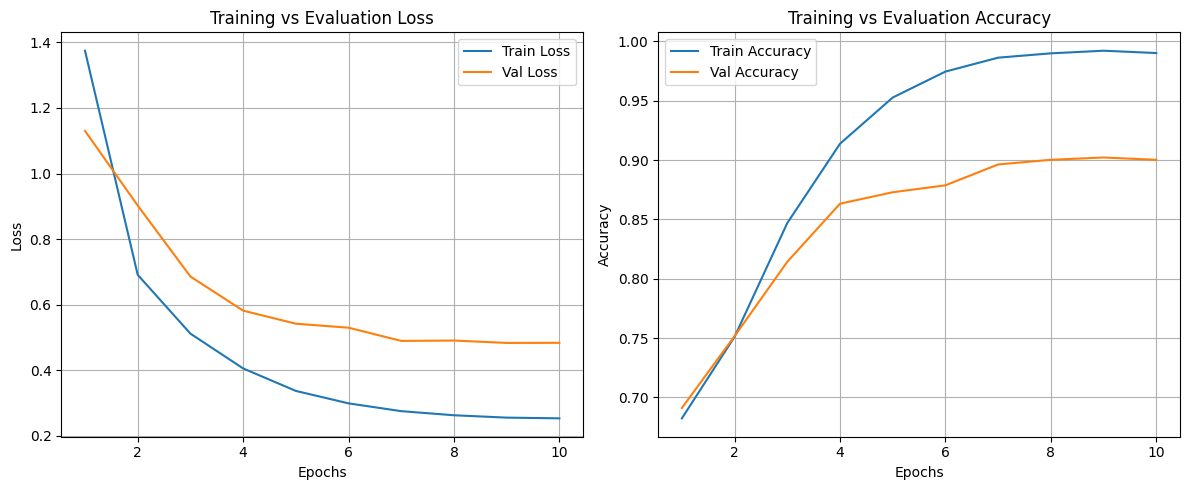

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Used as reference for plotting on the x-axis
x = range(1, len(history['train_loss']) + 1)

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(x, history['train_loss'], label='Train Loss')
plt.plot(x, history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Training vs Evaluation Loss")
plt.legend()
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(x, history['train_acc'], label='Train Accuracy')
plt.plot(x, history['val_acc'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training vs Evaluation Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluation on best model found during training (based on validation accuracy)

In [ ]:
# loading best saved model weights
vision_adapter_state = torch.load("vision_adapter_state.pt", weights_only=True)
text_adapter_state = torch.load("ctx_state.pt", weights_only=True)
best_student_model = CustomCLIP(
    CLASS_NAMES,
    clip_model,
    vision_adapter_args,
    text_adapter_args,
    vision_ratio,
    vision_adapter_state=vision_adapter_state,  # learned CLIP-adapter on the vision encoder
    text_adapter_state=text_adapter_state  # learned ctx
).to(DEVICE)

# ---- Compute accuracy on base and novel classes ----
baseLoader = torch.utils.data.DataLoader(
    test_base,
    batch_size=128,
    shuffle=False,
    num_workers=2,
    generator=g
)
novelLoader = torch.utils.data.DataLoader(
    test_novel,
    batch_size=128,
    shuffle=False,
    num_workers=2,
    generator=g
)

print()
_, base_accuracy = eval(best_student_model, baseLoader)
print(f"🔍 Base classes accuracy: {base_accuracy*100:.2f}%")
_, novel_accuracy = eval(best_student_model, novelLoader)
print(f"🔍 Novel classes accuracy: {novel_accuracy*100:.2f}%")
print(f"🔍 Harmonic Mean: {harmonic_mean(base_accuracy, novel_accuracy)*100:.2f}%")

Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



🔍 Base classes accuracy: 87.04%


🔍 Novel classes accuracy: 73.36%
🔍 Harmonic Mean: 79.62%
